In [141]:
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
%matplotlib inline

In [75]:
train_path = './data/train.csv'
test_path = './data/test.csv'
submission_path = './data/sample_submission.csv'

train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)
submission = pd.read_csv(submission_path)

In [76]:
data_all = pd.concat([train_data, test_data], axis=0, sort=True)

In [4]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 11 columns):
PassengerId    100000 non-null int64
Pclass         100000 non-null int64
Name           100000 non-null object
Sex            100000 non-null object
Age            96513 non-null float64
SibSp          100000 non-null int64
Parch          100000 non-null int64
Ticket         94819 non-null object
Fare           99867 non-null float64
Cabin          29169 non-null object
Embarked       99723 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 8.4+ MB


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
PassengerId    100000 non-null int64
Survived       100000 non-null int64
Pclass         100000 non-null int64
Name           100000 non-null object
Sex            100000 non-null object
Age            96708 non-null float64
SibSp          100000 non-null int64
Parch          100000 non-null int64
Ticket         95377 non-null object
Fare           99866 non-null float64
Cabin          32134 non-null object
Embarked       99750 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 9.2+ MB


# Filling missing values

In [77]:
#可以看到train和test中含有缺失值的属性是一致的
'''
Age:float
Ticket:object
Fare:float
Cabin:object
Embarked:object
'''
#Age
mean_age = data_all[['Age', 'Pclass']].groupby('Pclass').agg({'Age' : 'mean'}).to_dict()
#DataFrame的某一列值为Series，fillna方法必须是dict或者series，而agg返回了一个DateFrame
#DataFrame的map函数，Series或者DataFrame的某一列使用，参数为一个函数或者字典，表达的含义就是对于Series中的每一个元素执行函数或者执行字典映射
#填充data_all中的空值，填充依据是根据Pclass来进行median_age的映射
#median_age的形式如下，data_all['Pclass'].map(median_age['Age'])等同于data_all['Pclass'].map({1: 41.0, 2: 35.0, 3: 26.0})
data_all['Age'].fillna(data_all['Pclass'].map(median_age['Age']), inplace=True)

In [78]:
mean_age

{'Age': {1: 40.67275679580962, 2: 36.85506747527728, 3: 30.205569679012353}}

In [79]:
#Fare
mean_fare = data_all[['Fare', 'Pclass']].groupby('Pclass').agg({'Fare' : 'mean'}).to_dict()
data_all['Fare'].fillna(data_all['Pclass'].map(mean_fare['Fare']), inplace=True)

In [80]:
#Ticket
#Ticket是字符串+空格+数字的组合，如果有字符串，就用字符串代替Ticket，空或者纯数字用X来代替
data_all['Ticket'] = data_all['Ticket'].fillna('X').map(lambda x : str(x).split()[0] if len(str(x).split()) > 1 else 'X')

In [88]:
#Cabin
data_all['Cabin'] = data_all['Cabin'].fillna('X').map(lambda x : str(x)[0])

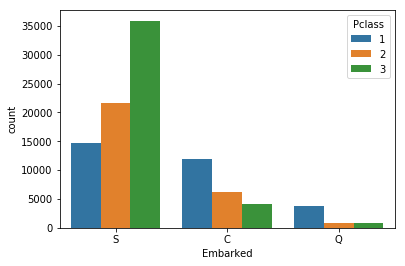

In [96]:
sns.countplot(x='Embarked', data=train_data, hue='Pclass')

In [94]:
#Embarked
#从图像上分析在S港口上船的人最多
data_all['Embarked'] = data_all['Embarked'].fillna('S')

In [95]:
data_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200000 entries, 0 to 99999
Data columns (total 12 columns):
Age            200000 non-null float64
Cabin          200000 non-null object
Embarked       200000 non-null object
Fare           200000 non-null float64
Name           200000 non-null object
Parch          200000 non-null int64
PassengerId    200000 non-null int64
Pclass         200000 non-null int64
Sex            200000 non-null object
SibSp          200000 non-null int64
Survived       100000 non-null float64
Ticket         200000 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 19.8+ MB


# Feature encoding

In [170]:
#数值型数据无需编码
numerical_cols = ['Age', 'Fare', 'Parch', 'Pclass',  'SibSp']
#非数值型数据编码，考虑one-hot或者labelencoder
'''
Cabin
Embarked
Sex
Ticket
'''
#one-hot编码
one_hot_cols = ['Cabin', 'Embarked', 'Sex']
#labelencoding
label_encoding_cols = ['Ticket']
le = LabelEncoder()

df_numerical = data_all[numerical_cols]
df_one_hot = pd.get_dummies(data_all[one_hot_cols])
data_all['Ticket'] = le.fit_transform(data_all['Ticket'])
df_label_encoding = data_all['Ticket']

In [171]:
data_encode = pd.concat([df_numerical, df_one_hot, df_label_encoding, data_all['Survived']], axis=1, sort=False)
# data_encode = pd.concat([df_numerical, df_one_hot, data_all['Survived']], axis=1, sort=False)

In [129]:
data_encode.head()

,Age,Fare,Parch,Pclass,SibSp,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,...,Cabin_G,Cabin_T,Cabin_X,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,Ticket,Survived
0,41.00,27.14,0,1,2,0,0,1,0,0,...,0,0,0,0,0,1,0,1,49,1.0
1,26.00,13.35,0,3,0,0,0,0,0,0,...,0,0,1,0,0,1,0,1,49,0.0
2,0.33,71.29,2,3,1,0,0,0,0,0,...,0,0,1,0,0,1,0,1,14,0.0
3,19.00,13.04,0,3,0,0,0,0,0,0,...,0,0,1,0,0,1,0,1,0,0.0
4,25.00,7.76,0,3,0,0,0,0,0,0,...,0,0,1,0,0,1,0,1,49,1.0


# XGBoost

In [172]:
#数据集划分
X_train, Y_train, X_test = data_encode[:train_data.shape[0]].drop(columns='Survived'), \
                            data_encode[:train_data.shape[0]]['Survived'], \
                            data_encode[train_data.shape[0]:].drop(columns='Survived')

In [173]:
X_train.shape

(100000, 20)

In [174]:
#注意包的引入是sklearn.model_selection不是sklearn.cross_validation
#StratifiedKFold(n_splits, shuffle, random_state)
#StratifiedKFold.split(X, y)
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
for fold_i, (train_idx, val_idx) in enumerate(skf.split(X_train, Y_train)):
    print("======FOLD:{}======".format(fold_i))
    x_train, y_train = X_train.iloc[train_idx], Y_train.iloc[train_idx]
    x_val, y_val = X_train.iloc[val_idx], Y_train.iloc[val_idx]
    '''
    XGBoost包的调用分为两种，一种是XGBoost.XGBClassifier,XGBoost.XGBRegressor,这种方法是利用sklearn中的包，使用方法和sklearn中的模型使用一样
    另外一种是XGBoost的原生接口
    objective是训练时的目标函数，eval_metric是验证使用的损失函数（不影响训练）
    clf默认的objective使用的是binary:logistic(二分类)，多分类使用multi:softmax,指定num_class
    reg默认的objective是reg:squarederror
    '''
    model = xgb.XGBClassifier(use_label_encoder=False, verbosity=1)
    print(model.objective)
    model.fit(x_train, y_train)
    val_pred = model.predict(x_val)
    print(val_pred)
    acc = accuracy_score(y_val, val_pred)
    print(acc)
    

======FOLD:0======
binary:logistic
[11:05:15] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0 0 1 ... 0 0 1]
0.7732226777322267
======FOLD:1======
binary:logistic
[11:05:16] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0 1 1 ... 0 0 0]
0.7806219378062194
======FOLD:2======
binary:logistic
[11:05:18] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0 0 0 ... 0 0 0]
0.7762223777622238
======FOLD:3======
binary:lo

In [175]:
pred_test = model.predict(X_test)
pred_test

array([0, 1, 1, ..., 0, 1, 1])

In [176]:
submission['Survived'] = pred_test
submission.to_csv('submission_xgb_all_one_hot.csv', index=False)

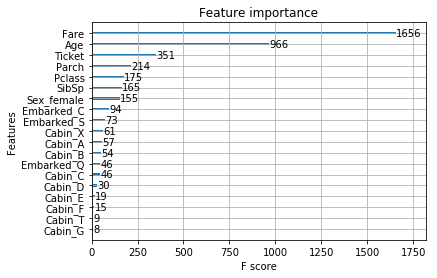

In [177]:
xgb.plot_importance(model)